<a href="https://colab.research.google.com/github/syedghazihaider/3-Tier-Dockerized-Application/blob/master/MLPROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Project title = Customer Churn and Behavior Analysis
#Name = Syed Ghazi Haider
#Roll number = 24k-7314

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Online Retail.xlsx to Online Retail.xlsx


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np
from datetime import datetime
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
# Target: 1 if Recency > 90 days (churned), else 0
from mlxtend.frequent_patterns import apriori
from prophet import Prophet
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import networkx as nx
from prophet.plot import plot_plotly
import plotly.offline as py
import shap
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
from sklearn.model_selection import TimeSeriesSplit

In [ ]:
df = pd.read_excel("Online Retail.xlsx")
print(df.head())
print(df.info())
print(df.describe())
print(df.isnull().sum())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       -----------

In [ ]:
# Remove canceled orders (InvoiceNo starting with 'C')
df = df[~df['InvoiceNo'].astype(str).str.contains('C')]

# Drop rows with missing CustomerID
df = df.dropna(subset=['CustomerID'])

# Convert CustomerID to integer
df['CustomerID'] = df['CustomerID'].astype(int)

# Add TotalPrice column
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

In [ ]:


# Set snapshot date (last invoice date + 1 day)
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# Calculate RFM metrics
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                  # Frequency
    'TotalPrice': 'sum'                                      # Monetary
}).rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalPrice': 'Monetary'
})

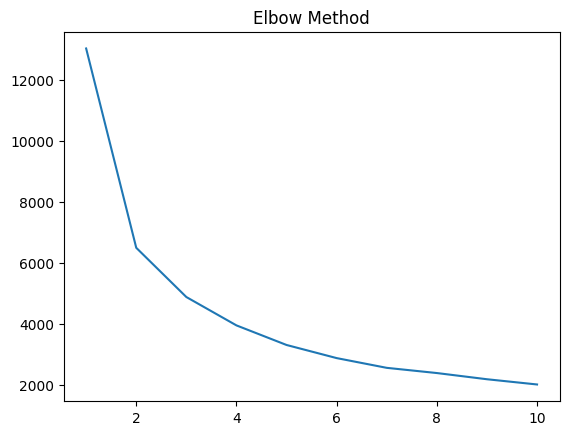

In [ ]:
# Log-transform to handle skewness
rfm_log = rfm[['Recency', 'Frequency', 'Monetary']].apply(np.log1p)

# Standardize
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)

# Elbow method to find optimal clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.show()

# Apply K-Means (assuming 4 clusters)
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

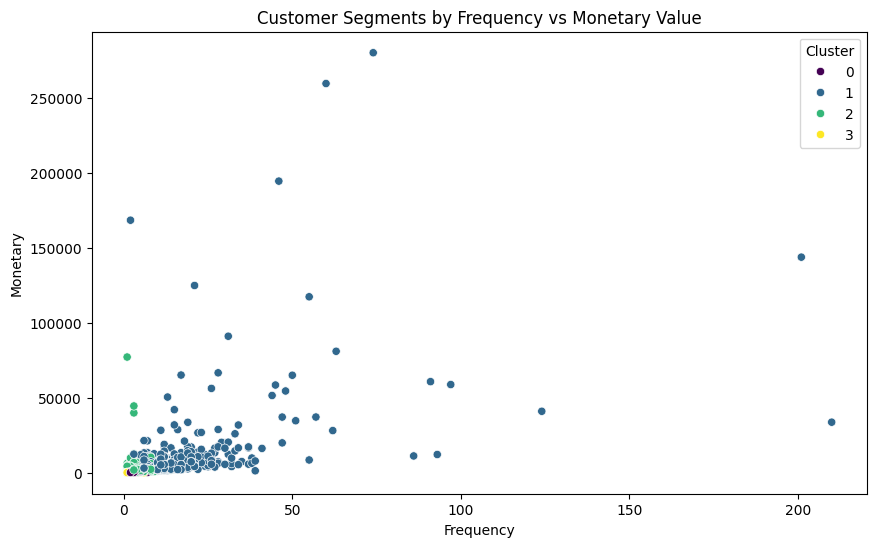

In [ ]:
# Cluster analysis
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
}).round(1)

# Plot clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='Frequency',
    y='Monetary',
    hue='Cluster',
    data=rfm,
    palette='viridis'
)
plt.title('Customer Segments by Frequency vs Monetary Value')
plt.show()

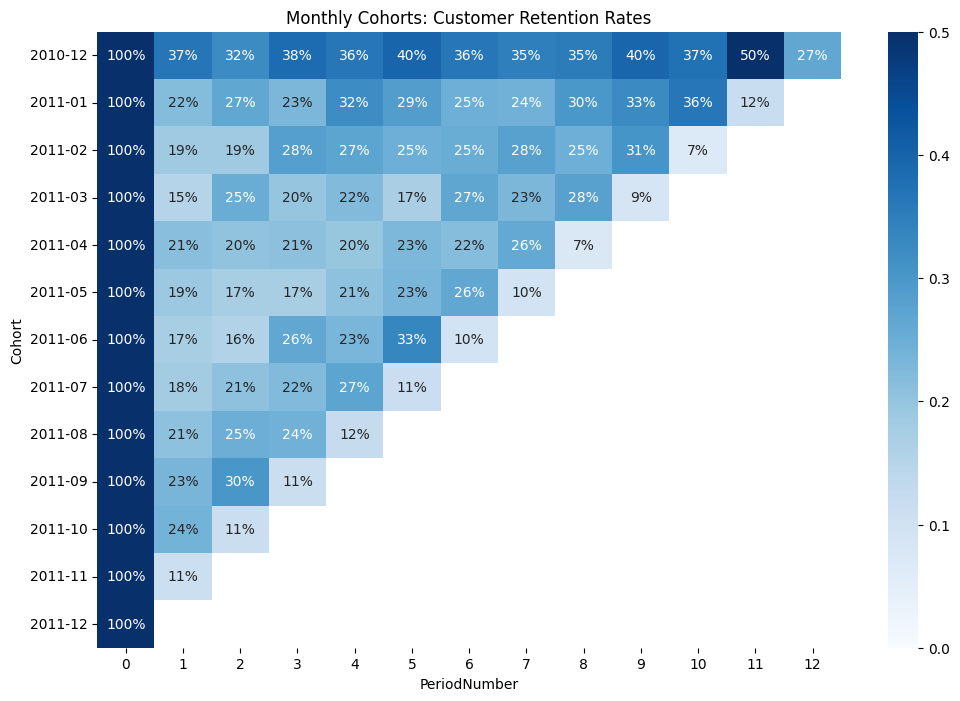

In [ ]:


# 1. Cohort Analysis (Fixed)
# Create cohort based on first purchase month
df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M')
df['Cohort'] = df.groupby('CustomerID')['InvoiceMonth'].transform('min')

# Calculate retention metrics
cohort_data = df.groupby(['Cohort', 'InvoiceMonth']).agg(
    n_customers=('CustomerID', 'nunique')
).reset_index()
cohort_data['PeriodNumber'] = (cohort_data['InvoiceMonth'] - cohort_data['Cohort']).apply(
    lambda x: x.n)

# Pivot for retention matrix
cohort_pivot = cohort_data.pivot_table(
    index='Cohort',
    columns='PeriodNumber',
    values='n_customers',
    aggfunc='sum'
)

# Calculate retention rates
cohort_size = cohort_pivot.iloc[:, 0]
retention_matrix = cohort_pivot.divide(cohort_size, axis=0)

# Visualize

plt.figure(figsize=(12, 8))
sns.heatmap(retention_matrix,
            annot=True,
            fmt='.0%',
            cmap='Blues',
            vmin=0.0,
            vmax=0.5)
plt.title('Monthly Cohorts: Customer Retention Rates')
plt.show()

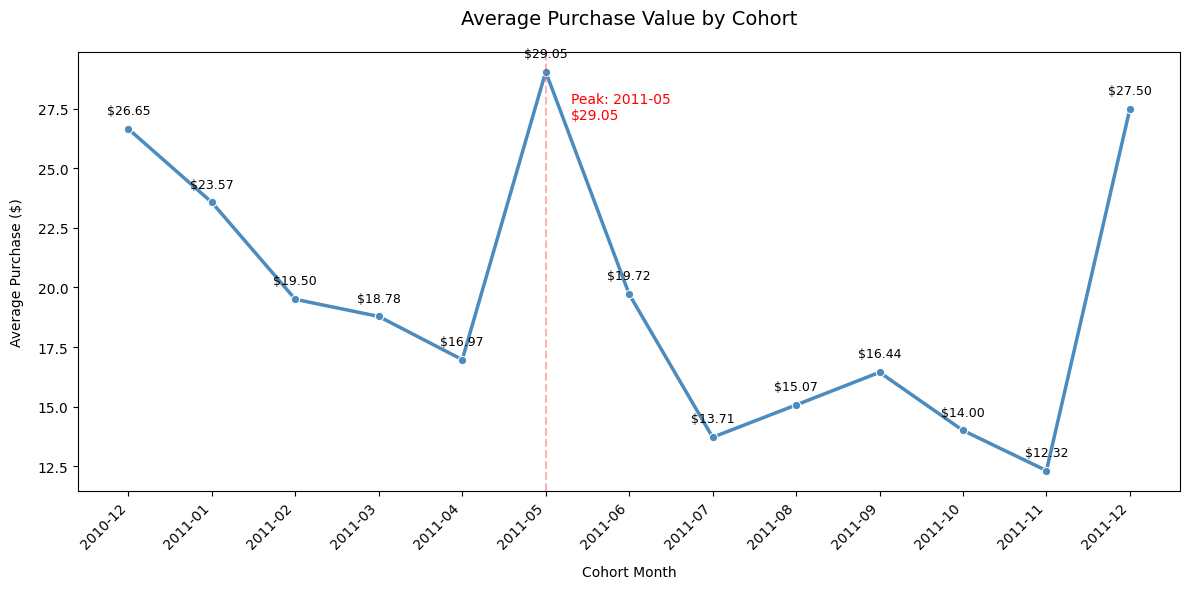

In [ ]:
# 1. Convert Cohort to string for plotting
cohort_clv['Cohort_Str'] = cohort_clv['Cohort'].astype(str)

# 2. Enhanced Visualization
plt.figure(figsize=(12, 6))
ax = sns.lineplot(
    data=cohort_clv,
    x='Cohort_Str',
    y='avg_purchase',
    marker='o',
    linewidth=2.5,
    color='#4B8BBE'
)

# 3. Professional Formatting
plt.title('Average Purchase Value by Cohort', pad=20, fontsize=14)
plt.xlabel('Cohort Month', labelpad=10)
plt.ylabel('Average Purchase ($)', labelpad=10)
plt.xticks(rotation=45, ha='right')

# 4. Add Value Annotations
for x, y in zip(cohort_clv.index, cohort_clv['avg_purchase']):
    ax.text(x, y+0.5, f'${y:.2f}',
            ha='center',
            va='bottom',
            fontsize=9)

# 5. Add Business Insights
max_cohort = cohort_clv.loc[cohort_clv['avg_purchase'].idxmax()]
plt.axvline(x=max_cohort.name,
            color='red',
            linestyle='--',
            alpha=0.3)
plt.text(max_cohort.name+0.3, max_cohort['avg_purchase']-2,
         f"Peak: {max_cohort['Cohort_Str']}\n${max_cohort['avg_purchase']:.2f}",
         color='red')

plt.tight_layout()
plt.show()

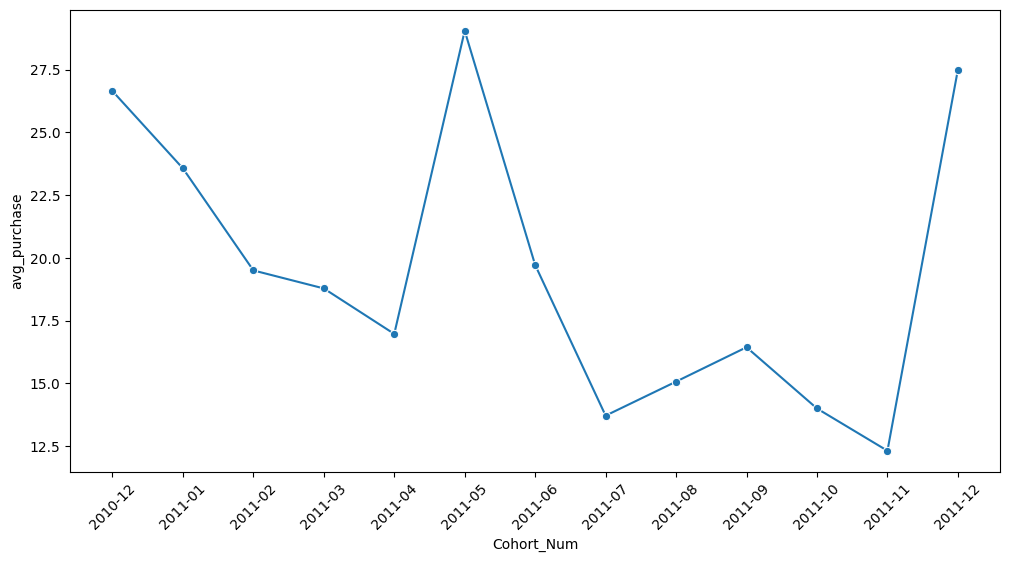

In [ ]:
# Convert Cohort to ordinal numbers
cohort_clv['Cohort_Num'] = range(len(cohort_clv))

plt.figure(figsize=(12, 6))
sns.lineplot(data=cohort_clv, x='Cohort_Num', y='avg_purchase', marker='o')
plt.xticks(ticks=cohort_clv.index,
           labels=cohort_clv['Cohort_Str'],
           rotation=45)
plt.show()

In [ ]:
# 1. Cohort Analysis (Retention Trends)
df['InvoicePeriod'] = df['InvoiceDate'].dt.to_period('M')
cohorts = df.groupby(['Cohort', 'InvoicePeriod']).agg(n_customers=('CustomerID', 'nunique')).reset_index()

# 2. Customer Lifetime Value (CLV)
clv = rfm['Monetary'].mean() * (rfm['Frequency'].mean() / (1 - (1 / rfm['Recency'].mean())))
print(f"Average CLV: ${clv:.2f}")

Average CLV: $8869.57


In [ ]:


# Feature Engineering
rfm['AvgPurchaseValue'] = rfm['Monetary'] / rfm['Frequency']
rfm['PurchaseCadence'] = rfm['Recency'] / rfm['Frequency']
rfm['Churned'] = (rfm['Recency'] > 90).astype(int)  # Target variable

# Prepare data
X = rfm[['Recency', 'Frequency', 'Monetary', 'AvgPurchaseValue', 'PurchaseCadence']]
y = rfm['Churned']

# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # Maintain class balance
)

# Hyperparameter Tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='f1',  # Focus on F1-score for imbalanced data
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

# Best model evaluation
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("=== Best Parameters ===")
print(grid_search.best_params_)

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))

print("\n=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))

=== Best Parameters ===
{'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100}

=== Classification Report ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       578
           1       1.00      1.00      1.00       290

    accuracy                           1.00       868
   macro avg       1.00      1.00      1.00       868
weighted avg       1.00      1.00      1.00       868


=== Confusion Matrix ===
[[578   0]
 [  0 290]]


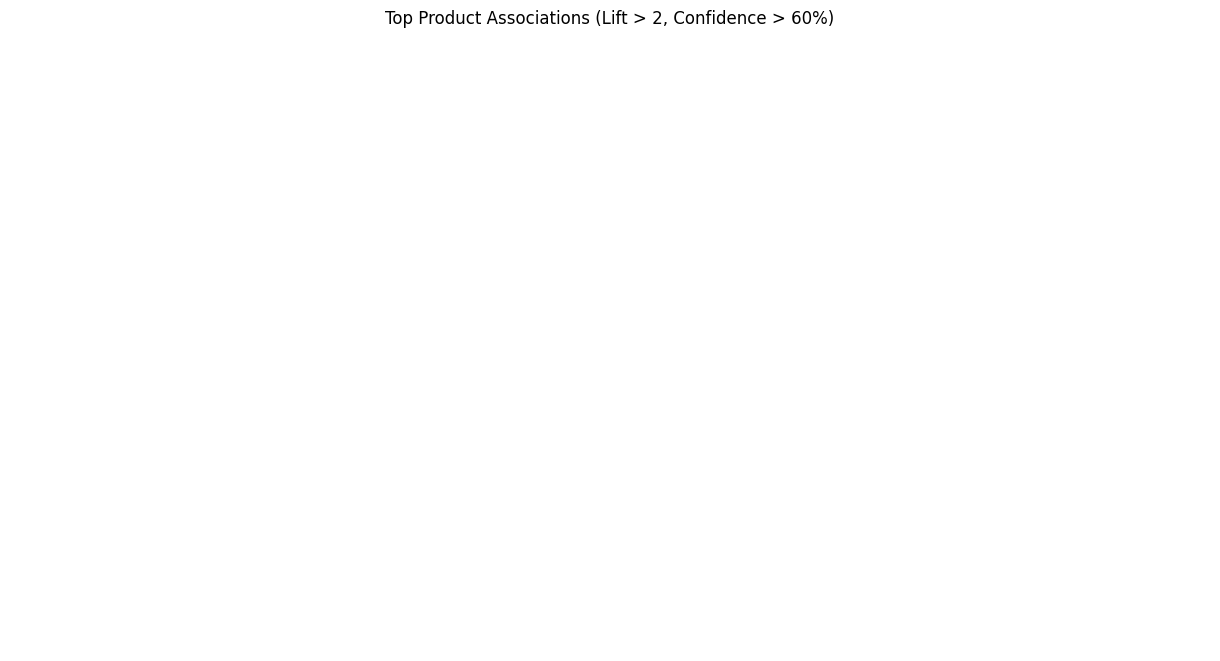

=== Top 5 Actionable Bundles ===


In [ ]:


# 1. Prepare Transaction Data
transactions = df.groupby('InvoiceNo')['Description'].apply(list).values.tolist()

# 2. One-Hot Encode Transactions
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
basket_df = pd.DataFrame(te_ary, columns=te.columns_)

# 3. Generate Frequent Itemsets
frequent_itemsets = apriori(
    basket_df,
    min_support=0.03,  # Items appear in 3% of transactions
    use_colnames=True,
    max_len=3  # Max itemset size
)

# 4. Generate Association Rules
rules = association_rules(
    frequent_itemsets,
    metric="lift",
    min_threshold=1.5  # At least 50% better than random
)

# 5. Filter Strong Rules
high_lift_rules = rules[
    (rules['lift'] > 2) &
    (rules['confidence'] > 0.6) &
    (rules['support'] > 0.04)
].sort_values('lift', ascending=False)

# 6. Visualize Top 10 Rules
plt.figure(figsize=(12, 6))
G = nx.from_pandas_edgelist(
    high_lift_rules.head(10),
    'antecedents',
    'consequents',
    edge_attr=['lift', 'confidence']
)

pos = nx.spring_layout(G, k=0.5)
nx.draw(
    G, pos,
    with_labels=True,
    node_size=2500,
    node_color='skyblue',
    font_size=10,
    width=[d['lift']*0.5 for (u,v,d) in G.edges(data=True)]
)
edge_labels = {(u,v): f"Lift: {d['lift']:.2f}\nConf: {d['confidence']:.2f}"
               for (u,v,d) in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.title("Top Product Associations (Lift > 2, Confidence > 60%)", pad=20)
plt.show()

# 7. Print Actionable Rules
print("=== Top 5 Actionable Bundles ===")
for idx, row in high_lift_rules.head(5).iterrows():
    print(f"\nBundle {idx+1}:")
    print(f"• Buy {', '.join(list(row['antecedents']))}")
    print(f"• Then buy: {', '.join(list(row['consequents']))}")
    print(f"► Confidence: {row['confidence']:.0%}")
    print(f"► Lift: {row['lift']:.1f}x improvement over random")

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaopy327m/gmuwybow.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaopy327m/_xyrhdxq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78461', 'data', 'file=/tmp/tmpaopy327m/gmuwybow.json', 'init=/tmp/tmpaopy327m/_xyrhdxq.json', 'output', 'file=/tmp/tmpaopy327m/prophet_model4neypn3c/prophet_model-20250516160240.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:02:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:02:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


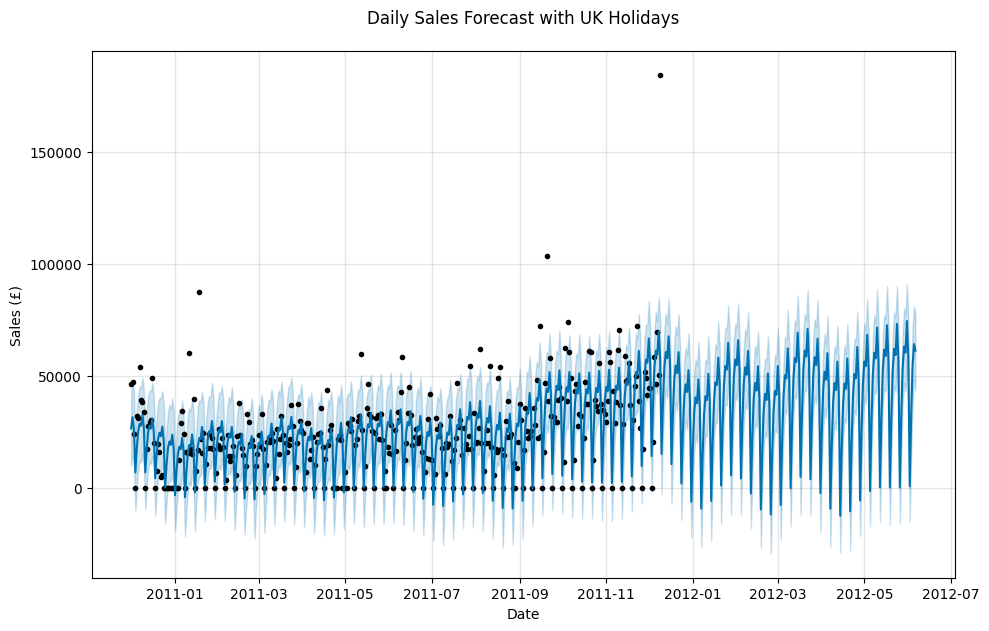

=== Top Holiday Impacts ===
Empty DataFrame
Columns: [ds, uk_holiday]
Index: []


In [ ]:


# 1. Prepare UK Holidays DataFrame (Manual Example)
uk_holidays_df = pd.DataFrame({
    'holiday': 'uk_holiday',
    'ds': pd.to_datetime([
        '2025-01-01',  # New Year's Day
        '2025-04-18',   # Good Friday
        '2025-04-21',   # Easter Monday
        '2025-05-05',   # Early May Bank Holiday
        '2025-05-26',   # Spring Bank Holiday
        '2025-08-25',   # Summer Bank Holiday
        '2025-12-25',   # Christmas Day
        '2025-12-26'    # Boxing Day
    ]),
    'lower_window': -2,  # 2 days before holiday
    'upper_window': 1     # 1 day after holiday
})

# 2. Prepare Sales Data (Daily Aggregation)
daily_sales = df.resample('D', on='InvoiceDate')['TotalPrice'].sum().reset_index()
daily_sales.columns = ['ds', 'y']

# 3. Initialize and Fit Model
model = Prophet(
    holidays=uk_holidays_df,
    seasonality_mode='multiplicative',
    yearly_seasonality=8,
    weekly_seasonality=3
)

# Optional: Add Marketing Spend Regressor (if available)
# model.add_regressor('marketing_spend')

model.fit(daily_sales)

# 4. Make Future DataFrame (6 months forecast)
future = model.make_future_dataframe(periods=180)
forecast = model.predict(future)

# 5. Visualize Results
fig1 = model.plot(forecast)
plt.title("Daily Sales Forecast with UK Holidays", pad=20)
plt.xlabel("Date")
plt.ylabel("Sales (£)")
plt.show()

# Interactive Plot (Zoomable)
fig2 = plot_plotly(model, forecast)
py.iplot(fig2)

# 6. Show Holiday Impacts
print("=== Top Holiday Impacts ===")
holiday_effects = forecast[
    (forecast['uk_holiday'] != 0) &
    (forecast['ds'].dt.year == 2025)
][['ds', 'uk_holiday']].drop_duplicates()
print(holiday_effects.sort_values('uk_holiday', ascending=False))


In [ ]:

explainer = shap.TreeExplainer(grid_search.best_estimator_)
shap_values = explainer.shap_values(X_test)

INFO:prophet:Making 5 forecasts with cutoffs between 2011-03-14 00:00:00 and 2011-11-09 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpaopy327m/qgvrdosg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaopy327m/ae25c1t3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9440', 'data', 'file=/tmp/tmpaopy327m/qgvrdosg.json', 'init=/tmp/tmpaopy327m/ae25c1t3.json', 'output', 'file=/tmp/tmpaopy327m/prophet_modelzkp5eqvi/prophet_model-20250516160449.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:04:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:04:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaopy327m/t679rlmw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaopy327m/pqbv5pmb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

=== Cross-Validation Metrics ===
  horizon           mse          rmse           mae     mdape     smape  \
0  3 days  1.877991e+08  13703.982646  11507.204364  0.329217  0.592506   
1  4 days  1.497343e+08  12236.595094  10277.514072  0.329217  0.564348   
2  5 days  1.854784e+08  13619.045639  10668.997605  0.378725  0.690388   
3  6 days  1.828577e+08  13522.488662  11011.675751  0.428850  0.632524   
4  7 days  2.475768e+08  15734.574187  12928.764848  0.443132  0.660519   

   coverage  
0  0.600000  
1  0.666667  
2  0.666667  
3  0.666667  
4  0.533333  


/usr/local/lib/python3.11/dist-packages/prophet/plot.py:546: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.

/usr/local/lib/python3.11/dist-packages/prophet/plot.py:547: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.



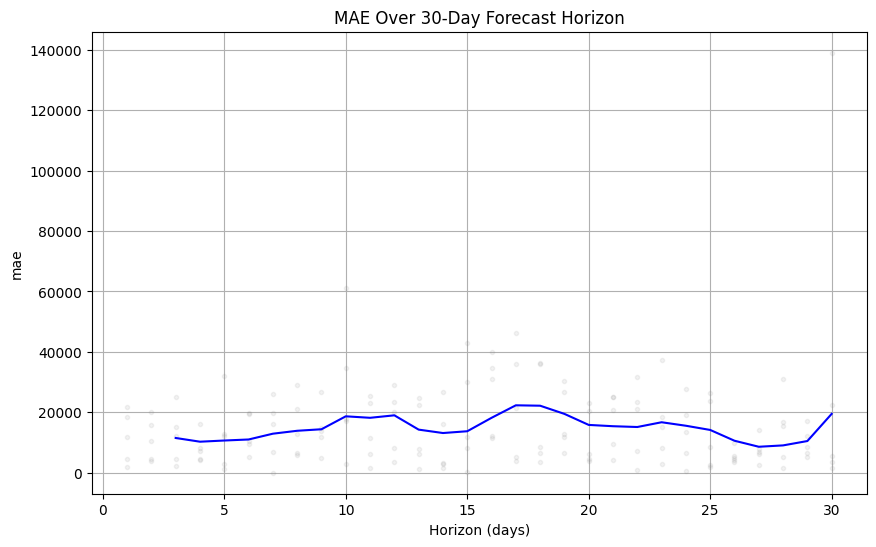

In [ ]:


# 1. Calculate safe CV parameters
n_hist = len(daily_sales)
min_days = 90  # Minimum training days
horizon_days = 30  # Forecast window
cv_days = 60  # Step between cutoff dates

# 2. Run Cross-Validation (with error handling)
try:
    df_cv = cross_validation(
        model,
        initial=f'{min_days} days',
        horizon=f'{horizon_days} days',
        period=f'{cv_days} days'
    )

    # 3. Calculate performance metrics
    df_p = performance_metrics(df_cv)
    print("=== Cross-Validation Metrics ===")
    print(df_p.head())

    # 4. Plot MAE over horizon
    fig = plot_cross_validation_metric(df_cv, metric='mae')
    plt.title(f'MAE Over {horizon_days}-Day Forecast Horizon')
    plt.show()

except Exception as e:
    print(f"Error: {e}\nTry reducing horizon/initial parameters.")
    print(f"Current data: {n_hist} days | Min required: {min_days + horizon_days} days")

In [ ]:


tscv = TimeSeriesSplit(n_splits=3)
for train_idx, test_idx in tscv.split(daily_sales):
    train = daily_sales.iloc[train_idx]
    test = daily_sales.iloc[test_idx]

    # Train and evaluate on each fold
    model = Prophet().fit(train)
    forecast = model.predict(test)
    # Calculate metrics...

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaopy327m/jck57o4y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaopy327m/vk65jhgx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86293', 'data', 'file=/tmp/tmpaopy327m/jck57o4y.json', 'init=/tmp/tmpaopy327m/vk65jhgx.json', 'output', 'file=/tmp/tmpaopy327m/prophet_models4uve6uz/prophet_model-20250516160506.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
16:05:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:05:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonali